In [11]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SwinConfig, SwinModel

# --- Cài đặt tham số cố định ---
IMG_SIZE = 320
BATCH_SIZE = 8
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Thay đổi đường dẫn thư mục tùy theo máy của bạn
train_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\image'
train_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\train\label'
val_img_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\image'
val_mask_dir = r'C:\Users\Admin\Documents\Python Project\DPL Crack detection\UDTIRI-Crack Detection\val\label'

# --- Thu thập đường dẫn tệp ảnh và mask ---
train_img_paths = sorted([os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)])
train_mask_paths = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)])
val_img_paths = sorted([os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)])
val_mask_paths = sorted([os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)])

class CrackDetectionDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, augment=False):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.augment = augment

        if len(self.image_filenames) != len(self.mask_filenames):
            raise ValueError("Number of image files and mask files do not match.") # Số lượng tệp ảnh và tệp mask không khớp.

    def __len__(self):
        return len(self.image_filenames)

    # Hàm thực hiện resize ảnh và mask về kích thước mong muốn (ban đầu)
    def resize_image_and_mask(self, img, mask, target_size=IMG_SIZE):
        img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
        return img, mask


    def __getitem__(self, idx):
        img = cv2.imread(self.image_filenames[idx])
        if img is None:
            raise ValueError(f"Could not read image file: {self.image_filenames[idx]}") # Không thể đọc tệp ảnh

        mask = cv2.imread(self.mask_filenames[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not read mask file: {self.mask_filenames[idx]}") # Không thể đọc tệp mask

        # Chuyển đổi ảnh sang RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Áp dụng Augmentation
        if self.augment:
            # Random Crop đầu tiên để có các phần khác nhau của ảnh
            # Đảm bảo ảnh đủ lớn để crop, nếu không, resize trước
            if img.shape[0] < IMG_SIZE or img.shape[1] < IMG_SIZE:
                img, mask = self.resize_image_and_mask(img, mask, target_size=IMG_SIZE)
            
            

            # Lật Ngang
            if random.random() < 0.5:
                img = cv2.flip(img, 1)
                mask = cv2.flip(mask, 1)
            # Lật Dọc
            if random.random() < 0.5:
                img = cv2.flip(img, 0)
                mask = cv2.flip(mask, 0)
        else:
            # Nếu không augment, chỉ resize về đúng kích thước IMG_SIZE
            img, mask = self.resize_image_and_mask(img, mask, target_size=IMG_SIZE)

        # Chuẩn hóa ảnh và mask về [0, 1]
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        
        # Đảm bảo mask có chiều kênh (1, H, W)
        if mask.ndim == 2: # Nếu mask vẫn là (H, W)
            mask = np.expand_dims(mask, axis=0) # Thêm chiều kênh ở vị trí 0 -> (1, H, W)
        elif mask.ndim == 3 and mask.shape[0] != 1: # Nếu là (C, H, W) nhưng C không phải 1
            if mask.shape[0] == 3: # Nếu là 3 kênh (ví dụ, mask gốc là RGB)
                mask = mask[0:1, :, :] # Lấy kênh đầu tiên
            else:
                raise ValueError(f"Mask has unexpected shape {mask.shape} at index {idx} after transform. Expected channel dim 1.") # Mask có hình dạng không mong muốn sau khi biến đổi. Expected channel dim 1.
        
        # Chuyển đổi từ NumPy array sang PyTorch tensor
        img_tensor = torch.from_numpy(img).permute(2, 0, 1) # Ảnh: (H, W, C) -> (C, H, W)
        mask_tensor = torch.from_numpy(mask) # Mask đã ở (1, H, W)

        return img_tensor, mask_tensor


Using device: cuda


In [12]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # Ưu tiên sử dụng nn.Upsample để tránh checkerboard artifacts
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # Lên gấp đôi kích thước không gian
            nn.Conv2d(in_channels, out_channels, kernel_size=1) # Giảm số kênh về out_channels
        )
        
        # Kích thước đầu vào cho ConvBlock sẽ là out_channels (từ upsample) + skip_channels
        self.conv_block = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip_features=None):
        # Bước 1: Upsample đầu vào x từ tầng trước đó
        x = self.upsample(x)
        # Tại đây, x đã có kích thước không gian lớn hơn (gấp đôi so với trước upsample)
        # và số kênh đã được điều chỉnh về out_channels.
        
        if skip_features is not None:
            # Bước 2: Đảm bảo kích thước không gian của skip_features khớp với x.
            # Đây là điểm sửa lỗi: nội suy skip_features để nó khớp với kích thước đã được upsample của x.
            if x.shape[2:] != skip_features.shape[2:]:
                skip_features = F.interpolate(skip_features, size=x.shape[2:], mode='bilinear', align_corners=True)
            
            # Bước 3: Nối (concatenate) x và skip_features theo chiều kênh
            x = torch.cat([x, skip_features], dim=1)
        
        # Bước 4: Chạy qua khối convolution để xử lý các đặc trưng đã nối
        x = self.conv_block(x)
        return x
    
class SwinUNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1):
        super().__init__()
        self.IMG_SIZE = IMG_SIZE

        # Cấu hình Swin-Base
        config = SwinConfig(image_size=self.IMG_SIZE, num_channels=input_channels,
                            patch_size=4, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32], # Swin-Base configs
                            window_size=7, mlp_ratio=4., qkv_bias=True, hidden_dropout_prob=0.0,
                            attention_probs_dropout_prob=0.0, drop_path_rate=0.1,
                            hidden_act="gelu", use_absolute_embeddings=False,
                            patch_norm=True, initializer_range=0.02, layer_norm_eps=1e-05,
                            out_features=["stage1", "stage2", "stage3", "stage4"])
        self.swin = SwinModel(config)

        # Bottleneck: input từ hidden_state[3] (config.embed_dim * 8 kênh)
        # For Swin-Base, embed_dim=128, so config.embed_dim * 8 = 1024
        self.bottleneck = ConvBlock(config.embed_dim * 8, config.embed_dim * 8)

        # Decoder 4: in_channels từ bottleneck (1024), skip từ hidden_state[3] (1024 kênh), ra 512 kênh
        self.decoder4 = DecoderBlock(in_channels=config.embed_dim * 8, skip_channels=config.embed_dim * 8, out_channels=config.embed_dim * 4) # 1024, 1024, 512
        
        # Decoder 3: in_channels từ decoder4 (512), skip từ hidden_state[2] (512 kênh), ra 256 kênh
        self.decoder3 = DecoderBlock(in_channels=config.embed_dim * 4, skip_channels=config.embed_dim * 4, out_channels=config.embed_dim * 2) # 512, 512, 256
        
        # Decoder 2: in_channels từ decoder3 (256), skip từ hidden_state[1] (256 kênh), ra 128 kênh
        self.decoder2 = DecoderBlock(in_channels=config.embed_dim * 2, skip_channels=config.embed_dim * 2, out_channels=config.embed_dim * 1) # 256, 256, 128
        
        # Decoder 1: in_channels từ decoder2 (128), skip từ hidden_state[0] (128 kênh), ra 64 kênh
        self.decoder1 = DecoderBlock(in_channels=config.embed_dim * 1, skip_channels=config.embed_dim * 1, out_channels=config.embed_dim // 2) # 128, 128, 64
        
        # Final Upsample: upsample cuối cùng không có skip
        self.final_upsample = DecoderBlock(in_channels=config.embed_dim // 2, skip_channels=0, out_channels=config.embed_dim // 4) # 64, 0, 32
        self.final_conv = nn.Conv2d(config.embed_dim // 4, num_classes, kernel_size=1)


    def forward(self, x):
        outputs = self.swin(pixel_values=x, output_hidden_states=True)
        # encoder_features sẽ lưu các skip connections cần thiết
        encoder_features = []

        # Các hidden_states của Swin-Base:
        # hidden_state[0]: (B, 4096, 128) -> reshape (B, 128, 64, 64)   (H/4)
        # hidden_state[1]: (B, 1024, 256) -> reshape (B, 256, 32, 32) (H/8)
        # hidden_state[2]: (B, 256, 512) -> reshape (B, 512, 16, 16) (H/16)
        # hidden_state[3]: (B, 64, 1024) -> reshape (B, 1024, 8, 8)    (H/32)
        # hidden_state[4]: (B, 64, 1024) -> after final LayerNorm

        # Trích xuất và định hình lại các đặc trưng từ Swin Transformer cho các skip connection:
        # Skip connection cho decoder1 (H/4): hidden_state[0]
        hs_skip_res_H4 = outputs.hidden_states[0]
        b, n, c = hs_skip_res_H4.shape
        s = int(np.sqrt(n))
        encoder_features.append(hs_skip_res_H4.permute(0, 2, 1).reshape(b, c, s, s)) # index 0

        # Skip connection cho decoder2 (H/8): hidden_state[1]
        hs_skip_res_H8 = outputs.hidden_states[1]
        b, n, c = hs_skip_res_H8.shape
        s = int(np.sqrt(n))
        encoder_features.append(hs_skip_res_H8.permute(0, 2, 1).reshape(b, c, s, s)) # index 1

        # Skip connection cho decoder3 (H/16): hidden_state[2]
        hs_skip_res_H16 = outputs.hidden_states[2]
        b, n, c = hs_skip_res_H16.shape
        s = int(np.sqrt(n))
        encoder_features.append(hs_skip_res_H16.permute(0, 2, 1).reshape(b, c, s, s)) # index 2

        # Skip connection cho decoder4 (H/32): hidden_state[3]
        hs_skip_res_H32 = outputs.hidden_states[3]
        b, n, c = hs_skip_res_H32.shape
        s = int(np.sqrt(n))
        encoder_features.append(hs_skip_res_H32.permute(0, 2, 1).reshape(b, c, s, s)) # index 3

        # Bottleneck feature: từ hidden_state[3] (config.embed_dim * 8 kênh, 8x8)
        x_bottleneck = outputs.hidden_states[3]
        b, n, c = x_bottleneck.shape
        s = int(np.sqrt(n))
        x_bottleneck = x_bottleneck.permute(0, 2, 1).reshape(b, c, s, s)
        
        x = self.bottleneck(x_bottleneck)

        # Giải mã:
        x = self.decoder4(x, encoder_features[3])
        x = self.decoder3(x, encoder_features[2])
        x = self.decoder2(x, encoder_features[1])
        x = self.decoder1(x, encoder_features[0])
        
        x = self.final_upsample(x)
        outputs = self.final_conv(x)

        return outputs

In [13]:
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, iou_weight=0.5, pos_weight_val=1.0, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        # Thêm pos_weight vào BCEWithLogitsLoss
        # pos_weight phải là tensor và ở cùng device với model
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_val]).to(DEVICE))
        self.iou_loss_instance = IoULoss(smooth=smooth)
        self.bce_weight = bce_weight
        self.iou_weight = iou_weight

    def forward(self, inputs, targets):
        bce_loss_val = self.bce_loss(inputs, targets)
        iou_loss_val = self.iou_loss_instance(inputs, targets)
        
        total_loss = self.bce_weight * bce_loss_val + self.iou_weight * iou_loss_val
        return total_loss



class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: prediction (logits)
        # targets: ground truth
        
        # Áp dụng sigmoid cho outputs để có giá trị trong [0, 1]
        inputs = torch.sigmoid(inputs)
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        union = (inputs + targets).sum() - intersection
        
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        return 1 - iou # Trả về 1 - IoU để tối thiểu hóa loss

def calculate_metrics(predicted_masks, true_masks, smooth=1e-6):
    intersection = (predicted_masks * true_masks).sum()
    union = (predicted_masks + true_masks).sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    # Dice/F1-score cũng là một metric tốt để theo dõi
    dice = (2. * intersection + smooth) / ((predicted_masks.sum() + true_masks.sum()) + smooth)
    f1_score = dice 

    return iou.item(), f1_score.item()

In [14]:

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, callbacks_config, start_epoch=0, best_val_loss_so_far=float('inf'), history=None):
    best_val_loss = best_val_loss_so_far 
    patience_counter = 0
    model_checkpoint_path = callbacks_config.get('checkpoint_path', 'swin_unet_best_pytorch.pth')
    
    # Khởi tạo hoặc tiếp tục từ history đã có
    if history is None:
        history = {
            'train_loss': [], 'val_loss': [],
            'train_iou': [], 'val_iou': [],
            'train_f1': [], 'val_f1': [],
            'lr': []
        }

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        running_f1 = 0.0
        print(f"Epoch {epoch+1}/{num_epochs} starting...")
        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(images) # outputs là logits

            loss = criterion(outputs, masks) # criterion (CombinedLoss) đã xử lý sigmoid bên trong cho IoU, và BCEWithLogitsLoss tự xử lý logits

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # Để tính metrics, cần áp dụng sigmoid cho outputs và sau đó ngưỡng
            predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
            
            batch_iou, batch_f1 = calculate_metrics(predicted_masks, masks)
            running_iou += batch_iou * images.size(0)
            running_f1 += batch_f1 * images.size(0)

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_iou = running_iou / len(train_loader.dataset)
        epoch_f1 = running_f1 / len(train_loader.dataset)
        
        # LƯU TRỮ TRAINING METRICS
        history['train_loss'].append(epoch_loss)
        history['train_iou'].append(epoch_iou)
        history['train_f1'].append(epoch_f1)

        print(f"Epoch {epoch+1} Finished - Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train F1-Score: {epoch_f1:.4f}")

        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)

                outputs = model(images) # outputs là logits
                loss = criterion(outputs, masks) # criterion (CombinedLoss) đã xử lý sigmoid bên trong

                val_loss += loss.item() * images.size(0)

                # Để tính metrics, cần áp dụng sigmoid cho outputs và sau đó ngưỡng
                predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
                
                batch_iou, batch_f1 = calculate_metrics(predicted_masks, masks)
                val_iou += batch_iou * images.size(0)
                val_f1 += batch_f1 * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)
        
        # LƯU TRỮ VALIDATION METRICS
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_f1'].append(val_f1)

        print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Validation F1-Score: {val_f1:.4f}")
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr) # Lưu trữ Learning Rate
        print(f"Current Learning Rate: {current_lr:.8f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"Best validation loss updated: {best_val_loss:.4f}. Saving model and state...")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'scheduler_state_dict': scheduler.state_dict(),
                'history': history # LƯU LỊCH SỬ HUẤN LUYỆN
            }, model_checkpoint_path)
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{callbacks_config['patience']}")
            if patience_counter >= callbacks_config['patience']:
                print("Early stopping!")
                break
        
    return history
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 5))

    # Biểu đồ Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'o-', label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Biểu đồ IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_iou'], 'o-', label='Train IoU')
    plt.plot(epochs, history['val_iou'], 'o-', label='Validation IoU')
    plt.title('Training and Validation IoU per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    # Biểu đồ F1-Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], 'o-', label='Train F1-Score')
    plt.plot(epochs, history['val_f1'], 'o-', label='Validation F1-Score')
    plt.title('Training and Validation F1-Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Biểu đồ Learning Rate (tùy chọn)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, history['lr'], 'o-', label='Learning Rate')
    plt.title('Learning Rate per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


SwinUNet(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
                 

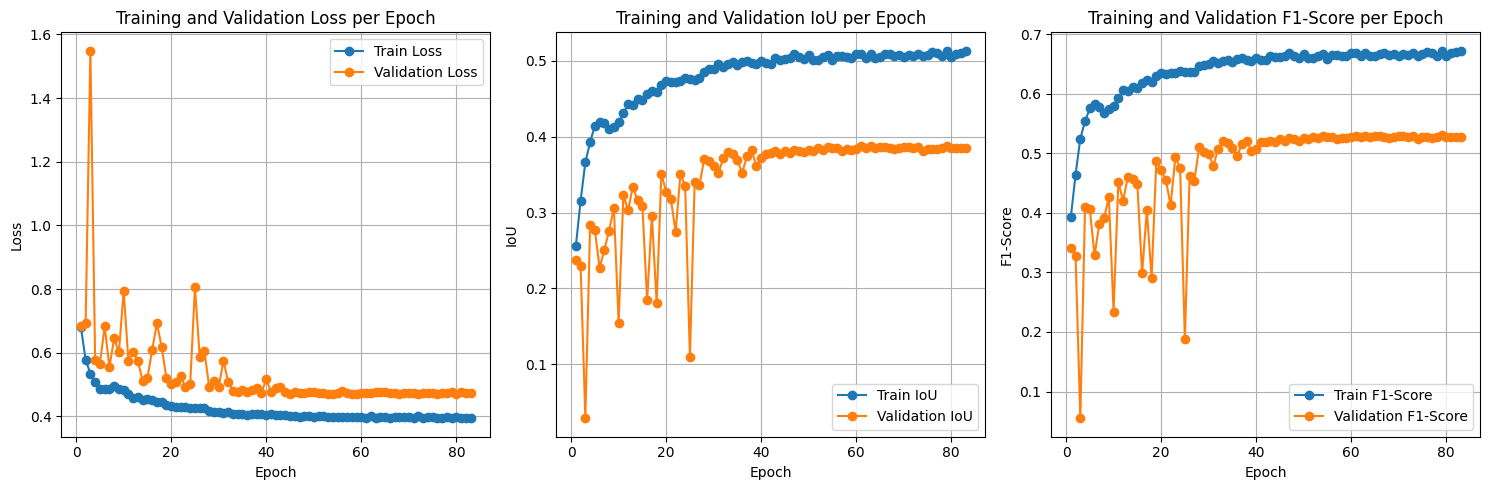

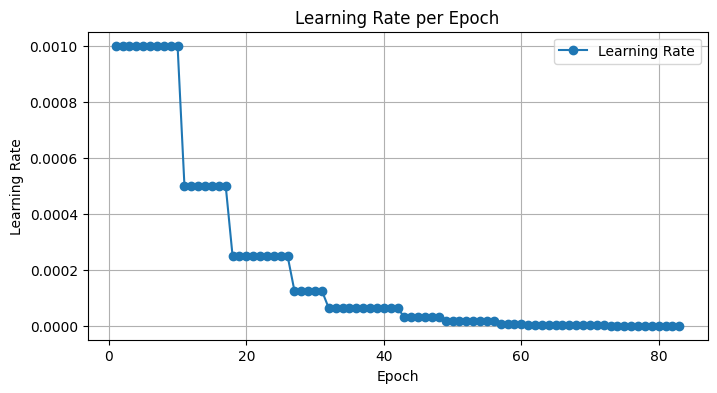

In [15]:
train_dataset = CrackDetectionDataset(train_img_paths, train_mask_paths, augment=True)
val_dataset = CrackDetectionDataset(val_img_paths, val_mask_paths, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- Khởi tạo mô hình, optimizer, criterion ---
model = SwinUNet(input_channels=3, num_classes=1).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7)

criterion = CombinedLoss(bce_weight=0.5, iou_weight=0.5, pos_weight_val=11.33)

print(model)

callbacks_config = {
    'patience': 30,
    'checkpoint_path': 'swin_unet_base_CombinedLoss_posweight.pth' # Đổi tên checkpoint để phân biệt
}

# --- Logic để tiếp tục huấn luyện từ checkpoint ---
start_epoch = 0
best_val_loss_so_far = float('inf')
checkpoint_path = callbacks_config['checkpoint_path']
history = None

if os.path.exists(checkpoint_path):
    print(f"Checkpoint found at {checkpoint_path}. Loading to resume training...")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Scheduler state loaded.")
    
    start_epoch = checkpoint['epoch'] + 1 
    best_val_loss_so_far = checkpoint['best_val_loss']
    
    if 'history' in checkpoint:
        history = checkpoint['history']
        print("Training history loaded from checkpoint.")
    else:
        print("No training history found in checkpoint. Starting new history.")

    print(f"Loaded checkpoint from Epoch {start_epoch-1}. Resuming training from Epoch {start_epoch}.")
    print(f"Previous best validation loss: {best_val_loss_so_far:.4f}")
else:
    print("No checkpoint found. Starting training from scratch (Epoch 0).")

print("\nStarting Swin-Unet Base model training (Combined BCE + IoU Loss with Pos_Weight)...")
training_history = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler,
                               num_epochs=10000, callbacks_config=callbacks_config,
                               start_epoch=start_epoch, best_val_loss_so_far=best_val_loss_so_far,
                               history=history)

print("\nTraining complete.")

if training_history is not None and len(training_history['train_loss']) > 0:
    plot_training_history(training_history)
else:
    print("No training history available to plot.")